## Introduction

First, you need to obtain and preprocess the data for the segmentation task
The data is provided by the medical segmentation decathlon challenge(http://medicaldecathlon.com/) <br />
You can directly download the full body cts and segmentation maps from: <br />
https://drive.google.com/file/d/1I1LR7XjyEZ-VBQ-Xruh31V7xExMjlVvi/view?usp=sharing

(Data License: CC-BY-SA 4.0, https://creativecommons.org/licenses/by-sa/4.0/)

## Imports
**Task: Import the necessary libraries**

* Pathlib for easy path handling
* nibabel as the files are provided in the NIfTI format
* numpy for data saving and processing
* matplotlib for plotting
* celluloid for nice volume visualization
* tqdm for nice progressing bars
* cv2 for resizing

In [28]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from tqdm.notebook import tqdm
import cv2


In [29]:
pwd

'D:\\Udemy-Medical PyTorch\\07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation\\07-CAPSTONE-PROJECT--Lung-Tumor-Segmentation\\Solution'

## Inspection:
Let's first inspect some sample data

**Task: Define the paths to images and labels**

In [30]:
root = Path("Task06_Lung/imagesTr/")
label = Path("Task06_Lung/labelsTr/")

**Task: Load a sample NIfTI and its corresponding label mask**<br />
Hint: You might want to define a helper function to make your life easier

In [31]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories whithin the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [52]:
sample_path = list(root.glob("lung*"))[5]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [53]:
sample_path, sample_path_label

(WindowsPath('Task06_Lung/imagesTr/lung_009.nii.gz'),
 WindowsPath('Task06_Lung/labelsTr/lung_009.nii.gz'))

Load NIfTI and extract image data

In [54]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata()

**Task: Find out the orientation**

In [55]:
nib.aff2axcodes(data.affine)

('L', 'A', 'S')

**Task: Inspect the loaded data with overlaid Ground Truth tumor segmentation**
Hint: Use the axial view (last axis)

<IPython.core.display.Javascript object>


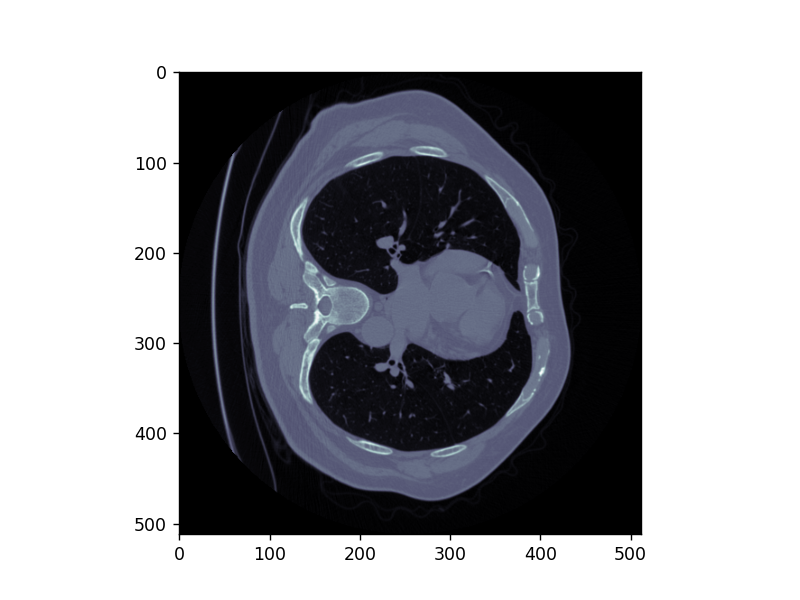

In [56]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid

for i in range(0, ct.shape[2], 2):  # axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="autumn")
    #plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




### Lung Tumor Segmentation using UNet

In [57]:
from IPython.display import HTML
HTML(animation.to_html5_video())  # convert the animation to a video


RuntimeError: Requested MovieWriter (ffmpeg) not available

## Preprocessing
**Task: Please perform the following preprocessing steps:**

1. CT images have a fixed range from -1000 to 3071. **Thus you could normalize by dividing by 3071** <br /> You don't need to compute mean and standard deviation for this task
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, **you might skip the first 30 slices (from lower abdomen to the neck)** (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost **you should store the preprocessed data as 2d files**, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

Additionally, please make sure that all scans have the same orientation

In the preprocessing loop, you need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

Store the last 6 subjects as validation data

PS: Feel free to try the lung window!

In [ ]:
all_files = list(root.glob("lung_*"))  # Get all subjects

In [ ]:
len(all_files)

In [ ]:
save_root = Path("Task06_Lung/Preprocessed")

for counter, path_to_ct_data in enumerate(tqdm(all_files)):
        
    path_to_label = change_img_to_label_path(path_to_ct_data)  # Get path to ground truth
    
    # Load and extract corresponding data
    ct_data = nib.load(path_to_ct_data).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()
    
    # Crop volume and label. Remove the first 30 slices  
    ct_data = ct_data[:,:,30:] / 3071
    label_data = label_data[:,:,30:]
        
    # Check if train or val data and create corresponding path
    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
    
    # Loop over the slices in the full volume and store the data and labels in the data/masks directory
    for i in range(ct_data.shape[-1]):
        slice = ct_data[:,:,i]
        mask = label_data[:,:,i]
        
        # Resize slice and label to common resolution to reduce training time
        slice = cv2.resize(slice, (256, 256))
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)
        
        
    

## Validate preprocessed data
**Task: Take a look at your stored files and inspect if everything worked as expected**

In [ ]:
path = Path("Task06_Lung/Preprocessed/train/2")  # Select a subject. Check the folder if it exists


In [ ]:
list(path.glob("*"))

In [ ]:
1# Choose a file and load slice + mask
file = "120.npy"
slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

In [ ]:
# Plot everything
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
axis[1].imshow(slice, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

In [ ]:
print(slice.min(), slice.max())

Nice! Everything is processed and we can continue to write the Dataset Class!